## Functions :
-***loadData*** : Load data from csv datasets 

-***visualizeData*** : Have a small insight on the Data

-***Df2Numpy*** : Converts pandas Dataframe to numpy array
***



In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import time


def dataAnalysis(R):
    nUsers = R.shape[0]
    nMovies = R.shape[1]
    
    # Number of rated movies per user
    ratingsPerUser = [sum(R[i, :] > 0) for i in range(nUsers)]
    maxRatingsPerUser = max(ratingsPerUser)
    minRatingsPerUser = min(ratingsPerUser)
    avgRatingsPerUser = sum(ratingsPerUser) / len(ratingsPerUser)
    print("Max ratings per user : ", maxRatingsPerUser)
    print("Min ratings per user : ", minRatingsPerUser)
    print("Avg ratings per user : ", avgRatingsPerUser)
    usersNoRatings = len([u for u in ratingsPerUser if u == 0])
    print("Users with no ratings : ", usersNoRatings)
    
    # Number of ratings per movie
    ratingsPerMovie = [sum(R[:, j] > 0) for j in range(nMovies)]
    maxRatingsPerMovie = max(ratingsPerMovie)
    minRatingsPerMovie = min(ratingsPerMovie)
    avgRatingsPerMovie = sum(ratingsPerMovie) / len(ratingsPerMovie)
    print("Max ratings per movie : ", maxRatingsPerMovie)
    print("Min ratings per movie : ", minRatingsPerMovie)
    print("Avg ratings per movie : ", avgRatingsPerMovie)
    moviesNoRatings = len([m for m in ratingsPerMovie if m == 0])            
    print("Movies with no ratings : ", moviesNoRatings)

def loadData1M(directory):
    """
        Takes as input the directory of the dataset. 
        Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.dat', delimiter="::", header=None, usecols=[0, 1, 2])
    ratings.columns = ['userId', 'movieId', 'rating']
    movies = pd.read_csv(directory + 'movies.dat', delimiter="::", header=None)
    return ratings, movies

def loadData(directory):
    """
        Takes as input the directory of the dataset. 
        Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.csv', usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv(directory + 'movies.csv')
    return ratings, movies

def visualizeData(ratings, movies):
    print('Ratings is a {} Frame'.format(ratings.shape))
    print(ratings.head())
    print('\n')
    print(ratings.describe())
    print('\n')
    print('Movies is a {} Frame'.format(movies.shape))
    print(movies.head())
    
    nUsers = len(ratings['userId'].unique())
    print("There are {} users in the dataset.".format(nUsers))
    nMovies = len(movies['movieId'].unique())
    print("There are {} movies in the dataset.".format(nMovies))
    
    ratings['rating'].hist(bins=50)
    
def Df2Numpy(ratings):
    ratingsMatrix = ratings.pivot(index='userId', columns='movieId', values='rating')
    ratingsMatrix = ratingsMatrix.fillna(0)
    R = ratingsMatrix.to_numpy()
    return R
    
class MatrixFactorization():
    """
        A Simple Matrix Factorization Class.
        Assumes ratings is a m x n Numpy Array. 
        nFactors is the intermediate dimension k of the Matrices U and V.
        lambdaReg and muReg are regularization parameters.
        Blabla..
    """
    def __init__(self, 
                 ratings, 
                 nFactors=10, 
                 lambdaReg=0.0, 
                 muReg=0.0, 
                 withBias=True, 
                 userBiasReg=0.0, 
                 movieBiasReg=0.0, 
                 alpha=0.001, 
                 maxIter=100, 
                 epsilon=0.001, 
                 trainFrac=0.8, 
                 valFrac=0.1, 
                 testFrac=0.1, 
                 mean=0.0, 
                 sd=1.0):
        np.random.seed(0) #Fix seed
        self.R = ratings
        self.nFactors = nFactors
        self.lambdaReg = lambdaReg
        self.muReg = muReg
        self.userBiasReg = userBiasReg
        self.movieBiasReg = movieBiasReg
        self.nUsers, self.nMovies = ratings.shape
        self.alpha = alpha
        self.maxIter = maxIter
        self.U = np.random.normal(size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(size=(self.nMovies, self.nFactors))
        self.userBias = np.zeros(self.nUsers)
        self.movieBias = np.zeros(self.nMovies)
        self.samples = self.matrix2Samples(ratings)
        self.nSamples = len(self.samples)
        self.epsilon = epsilon
        self.trainFrac = trainFrac
        self.valFrac = valFrac
        self.testFrac = testFrac
        self.mean = mean
        self.sd = sd
        self.globalBias = 0
        self.withBias = withBias
        
    def randomInit(self,mean,sd):
        self.U = np.random.normal(loc=mean, scale=sd, size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(loc=mean, scale=sd, size=(self.nMovies, self.nFactors))
        
    def matrix2Samples(self, R):
        samples = [(i, j, R[i,j]) for i in range(self.nUsers)
           for j in range(self.nMovies) if R[i,j] > 0]
        return samples
    
    def Samples2Matrix(self, samples, m, n):
        matrix = np.zeros(m, n)
        for s in samples:
            i, j, v = s
            matrix[i, j] = v
        return matrix
    
    
    def splitTrainValTestOld(self):
        """
            Shuffle the samples and sends back a partition for training, validation and testing
        """ 
        np.random.shuffle(self.samples)
        nSamples = len(self.samples)
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainSamples, valSamples, testSamples = self.samples[:e1], self.samples[e1:e2], self.samples[e2:]
        
        # This can be removed if the split is only performed once
        for s in trainSamples:
            i, j, r = s
            self.R[i, j] = r
        
        for s in valSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        for s in testSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainSamples, valSamples, testSamples
    
    def splitTrainValTest(self):
        cpt = 0
        trainSamples = []
        valSamples = [] 
        testSamples = []
        for i in range(self.nUsers):
            ratingsIdx = [j for j in range(self.nMovies) if self.R[i, j] > 0]
            np.random.shuffle(ratingsIdx)
            nRatings = len(ratingsIdx)
            e1 = math.floor(self.trainFrac * nRatings)
            e2 = math.floor(self.trainFrac * nRatings) + math.floor(self.valFrac * nRatings) 
            cpt += nRatings
            trainIdx, valIdx, testIdx = ratingsIdx[:e1], ratingsIdx[e1:e2], ratingsIdx[e2:]
            trainSamples.extend([(i, j, self.R[i, j]) for j in trainIdx])
            valSamples.extend([(i, j, self.R[i, j]) for j in valIdx])
            testSamples.extend([(i, j, self.R[i, j]) for j in testIdx])
            
        for s in trainSamples:
            i, j, r = s
            self.R[i, j] = r
        
        for s in valSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        for s in testSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        if self.nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR : ', cpt, ' ', self.nSamples, ' ', len(trainSamples) + len(valSamples) + len(testSamples))

        return trainSamples, valSamples, testSamples
    
    def setGlobalBias(self, trainSamples):
        self.globalBias = sum([s[2] for s in trainSamples]) / len(self.samples)
    
    def splitTrainValSets(self, nGrades=10):
        """
        Split the observed data (nonzero entries) into a training set
        and a validation set by removing 10 grades per user and assigning them
        to the validation set
        """
        valMatrix = np.zeros(self.R.shape)
        trainMatrix = self.R.copy()
        for i in range(self.R.shape[0]):
            valRatingsIds = np.random.choice(self.R[i, :].nonzero()[0],
                                             size=nGrades,
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = self.R[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        trainSamples = self.matrix2Samples(trainMatrix)
        valSamples = self.matrix2Samples(valMatrix)
        return trainSamples, valSamples
    
    def trainValTestIdx(self):
        # Returns a partitions of indices 
        nSamples = len(self.samples)
        interval = range(nSamples)
        np.random.shuffle(interval)
        
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainIdx, valIdx, testIdx = interval[:e1], interval[e1:e2], interval[e2:]
        
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainIdx, valIdx, testIdx
    
    def stochasticGradientDescentPass(self, trainSamples):
        #tmpU = np.zeros(self.nFactors)
        #tmpV = np.zeros(self.nFactors)
        for s in trainSamples:
            i, j, r = s
            r_hat_ij = np.dot(self.U[i, :], self.V.T[:, j]) + self.userBias[i] + self.movieBias[j] + self.globalBias
            eij = r - r_hat_ij 
            
            tmpU = self.U[i, :] + self.alpha * (eij * self.V[j, :] - self.lambdaReg * self.U[i, :])
            tmpV = self.V[j, :] + self.alpha * (eij * self.U[i, :] - self.muReg * self.V[j, :])
            
            #for q in range(self.nFactors):
            #    tmpU[q] = self.U[i, q] + self.alpha * (eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
            #    tmpV[q] = self.V[j, q] + self.alpha * (eij * self.U[i, q] - self.muReg * self.V[j, q])
            
            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]
            
            if self.withBias:
                self.userBias[i] = self.userBias[i] + self.alpha * (eij - self.userBiasReg * self.userBias[i])
                self.movieBias[j] = self.movieBias[j] + self.alpha * (eij - self.movieBiasReg * self.movieBias[j])
            
        return self.U, self.V
    
    def coordinateDescentIteration(self):
        for i in range(self.nUsers):
            for q in range(self.nFactors):
                self.U[i, q] = sum([(R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                                     + self.U[i, q] * self.V[j, q]) * self.V[j, q] for j in range(self.nMovies) if R[i, j] > 0]) \
                                   / (self.lambdaReg + sum([self.V[j, q] ** 2 for j in range(self.nMovies) if R[i, j] > 0]))
        for j in range(self.nMovies):
            for q in range(self.nFactors):
                self.V[j, q] = sum([(R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                                     + self.U[i, q] * self.V[j, q]) * self.U[i, q] for i in range(self.nUsers) if R[i, j] > 0]) \
                                    / (self.muReg + sum([self.U[i, q] ** 2 for i in range(self.nUsers) if R[i, j] > 0]))
                                   
    def coordinateDescent(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit(self.mean, self.sd)
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        for i in range(self.maxIter):
            self.coordinateDescentIteration()
            trainError = self.computeTotalErrorSamples(trainSamples)
            
            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history

    def gridSearch(self, factors, alphas, lambdaRegs, muRegs):
        lowest_error = math.inf
        best_config = None
        bestSolution = (None, None)
        for config in itertools.product(factors, alphas, lambdaRegs, muRegs):
            self.nFactors, self.alpha, self.lambdaReg, self.muReg = config
            U, V, history = self.stochasticGradientDescent(False)
            if history['valError'] < lowest_error:
                lowest_error = history['valError']
                best_config = config
                bestSolution = (U, V)
                
        self.U, self.V = bestSolution    # Just for consistency 
        
        return U, V, best_config
            
            
    def stochasticGradientDescent(self, logging=True):
        history = {'trainErrors':[], 'valErrors':[]}
        self.randomInit(mean = self.mean, sd = self.sd)
        #self.NonRandomInit()
        trainSamples, valSamples, testSamples = self.splitTrainValTest()  # This should probably be outside ?
        self.setGlobalBias(trainSamples)
        for i in range(self.maxIter):
            # I think we should shuffle the data here. 
            np.random.shuffle(trainSamples)
            U, V = self.stochasticGradientDescentPass(trainSamples)
            
            if logging:
                trainError = self.computeTotalErrorSamples(trainSamples)
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history


    def computeTotalErrorSamples(self, data):
        error = 0
        if len(data) == 0:
            return 0
        for s in data:
            i, j, r = s
            error += (r - np.dot(self.U[i, :], self.V.T[:, j]) - self.userBias[i] - self.movieBias[j] - self.globalBias) ** 2
        return math.sqrt(error / len(data))

    def plotHistory(self, history, title): 
        plt.plot(history['trainErrors'], label='Training Error')
        plt.plot(history['valErrors'], label='Validation Error')
        plt.title(title)
        plt.ylabel('RMSE')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()
        
    def computeApproximatedMatrix(self, U, V):
        return np.dot(U, V.T)
    
    def alsUserStep(self, i):
        u = np.dot(
            np.linalg.inv(sum([np.outer(self.V[j, :], self.V[j, :]) 
                            for j in range(self.nMovies) if self.R[i, j] > 0]) + 
                               self.lambdaReg * np.eye(self.nFactors)), 
            sum([(self.R[i,j] - self.userBias[i] - self.movieBias[j] - self.globalBias) * self.V[j, :] for j in range(self.nMovies) if self.R[i, j] > 0])
        )
        
        
        # Maybe totally wrong
        # We do we update the biases ? As an independent block vector ? Or one coordinate at the time ?
        if self.withBias:
            self.userBias[i] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                 - self.movieBias[j] - self.globalBias \
              for j in range(self.nMovies) if R[i, j] > 0]) / (self.userBiasReg + len([1 for j in range(self.nMovies) if R[i, j] > 0]))
                #self.movieBias[j] = self.movieBias[j] + self.alpha * (eij - self.movieBiasReg * self.movieBias[j])
        return u
    
    def alsMovieStep(self, j):
        #try: 
        v = np.dot(
        np.linalg.inv(sum([np.outer(self.U[i, :], self.U[i, :]) 
                            for i in range(self.nUsers) if self.R[i, j] > 0]) +
                               self.muReg * np.eye(self.nFactors)), 
        sum([(self.R[i,j] - self.userBias[i] - self.movieBias[j] - self.globalBias) * self.U[i, :] for i in range(self.nUsers) if self.R[i, j] > 0])
        )
        
        # Need to be checked
        if self.withBias:
            self.movieBias[j] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                  - self.userBias[i] - self.globalBias \
                  for i in range(self.nUsers) if R[i, j] > 0]) / (self.movieBiasReg + len([1 for i in range(self.nUsers) if R[i, j] > 0]))
        
        #except :
        #    break
        return v
    
    def alsIteration(self):
        tmpU = np.zeros((self.nUsers, self.nFactors))
        tmpV = np.zeros((self.nMovies, self.nFactors))
        
        for i in range(self.nUsers):
            if any([self.R[i, j] > 0 for j in range(self.nMovies)]):
                tmpU[i, :] = self.alsUserStep(i)
        
        self.U = tmpU
        for j in range(self.nMovies):
            if any([self.R[i, j] > 0 for i in range(self.nUsers)]):
                tmpV[j, :] = self.alsMovieStep(j)
            
        self.V = tmpV
        
    def als(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit(self.mean, self.sd)
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        self.setGlobalBias(trainSamples)
        for i in range(self.maxIter):
            #np.random.shuffle(trainSamples)
            self.alsIteration()
            
            if logging:
                trainError = self.computeTotalErrorSamples(trainSamples)
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return self.U, self.V, history
    
# Generates a rank(k) matrix. Should add some noise..    
def syntheticMatrix(m, n, k):
    basis = np.random.randint(3, size=(m, k))
    matrix = np.zeros((m, n))
    coeffs = np.random.randint(3, size=k)
    
    for i in range(n):
        coeffs = np.random.randint(4, size=k)
        matrix[:, i] = sum([coeffs[j] * basis[:, j] for j in range(k)]) # TODO: + some small noise vector
         
    return matrix

In [38]:
plt.style.use('projet.mplstyle')

In [39]:
ratings, movies = loadData('Data/')

In [32]:
# Test SGD without bias
R_sgd = Df2Numpy(ratings)
mf_sgd = MatrixFactorization(R_sgd, 
                             nFactors=5,
                             alpha=0.01,
                             lambdaReg=0.1, 
                             muReg=0.1, 
                             trainFrac=0.8, 
                             valFrac=0.2, 
                             testFrac=0.0,
                             withBias=False,
                            maxIter=100)
U_sgd, V_sgd, history_sgd = mf_sgd.stochasticGradientDescent(True)

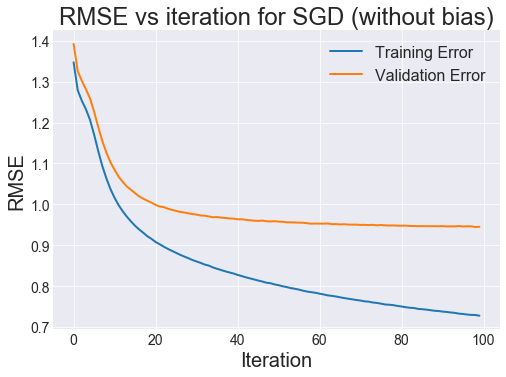

Training error : 0.73
Validation error : 0.95


In [33]:
mf_sgd.plotHistory(history_sgd, title='RMSE vs iteration for SGD (without bias)')
print("Training error : {0:.2f}".format(history_sgd['trainError']))
print("Validation error : {0:.2f}".format(history_sgd['valError']))

In [41]:
# Test SGD with bias
R_bsgd = Df2Numpy(ratings)
mf_bsgd = MatrixFactorization(R_bsgd, 
                             nFactors=5, 
                             lambdaReg=0.1, 
                             muReg=0.1,
                             userBiasReg=0.1,
                             movieBiasReg=0.1,
                             trainFrac=0.8, 
                             valFrac=0.2, 
                             testFrac=0.0,
                             withBias=True)
U_bsgd, V_bsgd, history_bsgd = mf_bsgd.stochasticGradientDescent(True)

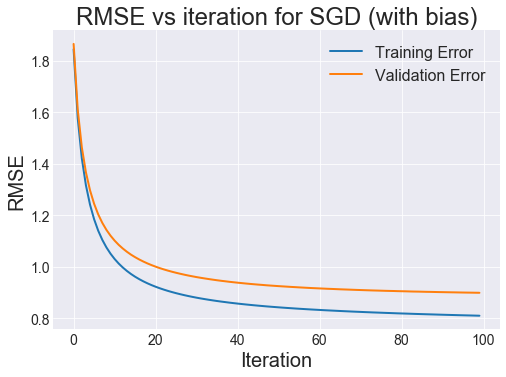

Training error : 0.81
Validation error : 0.90


In [43]:
mf_bsgd.plotHistory(history_bsgd, title='RMSE vs iteration for SGD (with bias)')
print("Training error : {0:.2f}".format(history_bsgd['trainError']))
print("Validation error : {0:.2f}".format(history_bsgd['valError']))

In [52]:
# Test ALS without bias
t1 = time.time()
R_als = Df2Numpy(ratings)
mf_als = MatrixFactorization(R_als, 
                             nFactors=5, 
                             lambdaReg=0.1, 
                             muReg=0.1, 
                             userBiasReg=0.0,
                             movieBiasReg=0.0,
                             trainFrac=0.8, 
                             valFrac=0.2, 
                             testFrac=0.0,
                             withBias=False,
                             maxIter =100)
U_als, V_als, history_als = mf_als.stochasticGradientDescent(True)
t2 = time.time()
print(t2-t1)

308.34852409362793


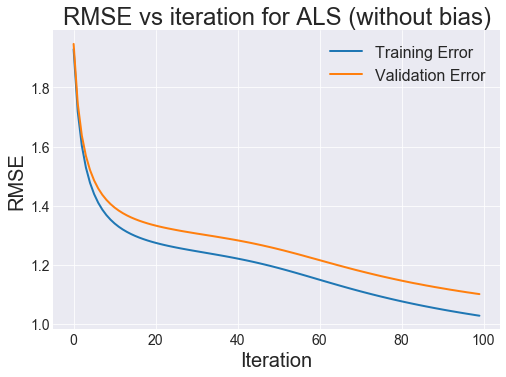

Training error : 1.03
Validation error : 1.10


In [54]:
mf_als.plotHistory(history_als, title='RMSE vs iteration for ALS (without bias)')
print("Training error : {0:.2f}".format(history_als['trainError']))
print("Validation error : {0:.2f}".format(history_als['valError']))

In [56]:
# Test ALS with bias
t1 = time.time()
R_bals = Df2Numpy(ratings)
mf_bals = MatrixFactorization(R_bals, 
                             nFactors=5, 
                             lambdaReg=0.1, 
                             muReg=0.1, 
                             userBiasReg=0.0,
                             movieBiasReg=0.0,
                             trainFrac=0.8, 
                             valFrac=0.2, 
                             testFrac=0.0,
                             withBias=True, 
                             maxIter=50)
U_bals, V_bals, history_bals = mf_bals.stochasticGradientDescent(True)
t2 = time.time()

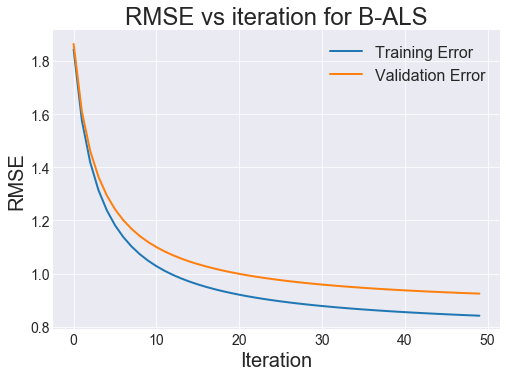

Training error : 0.84
Validation error : 0.92


In [58]:
mf_bals.plotHistory(history_bals, title='RMSE vs iteration for B-ALS')
print("Training error : {0:.2f}".format(history_bals['trainError']))
print("Validation error : {0:.2f}".format(history_bals['valError']))

In [ ]:
import progressbar

In [ ]:
# Test Regularisation effect illustrated with stochastic gradient descent
regRange = [0, 0.01, 0.1, 1, 10]
historyList = []
for reg in regRange:
    R_sgd = Df2Numpy(ratings)
    mf_sgd = MatrixFactorization(R_sgd, 
                                 nFactors=5,
                                 alpha=0.01,
                                 lambdaReg=reg, 
                                 muReg=reg, 
                                 trainFrac=0.8, 
                                 valFrac=0.2, 
                                 testFrac=0.0,
                                 withBias=False,
                                 maxIter=100)
    _, _, history_sgd = mf_sgd.stochasticGradientDescent()
    historyList.append(history_sgd)

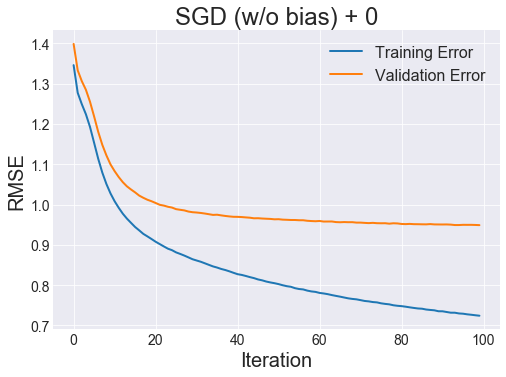

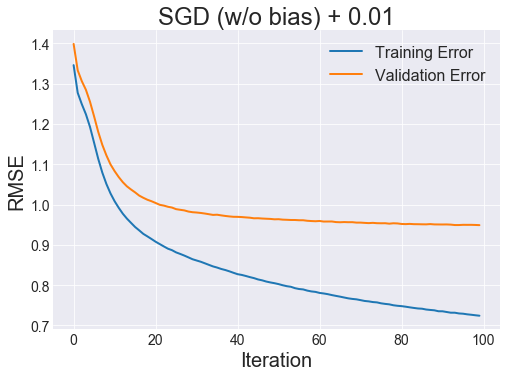

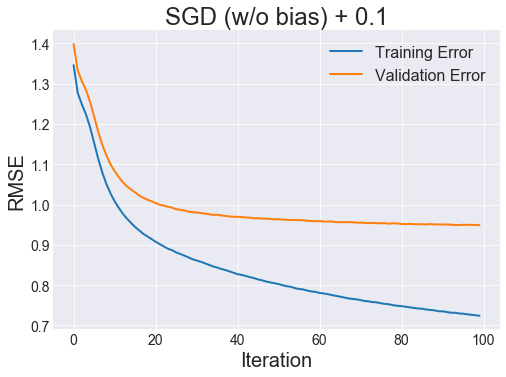

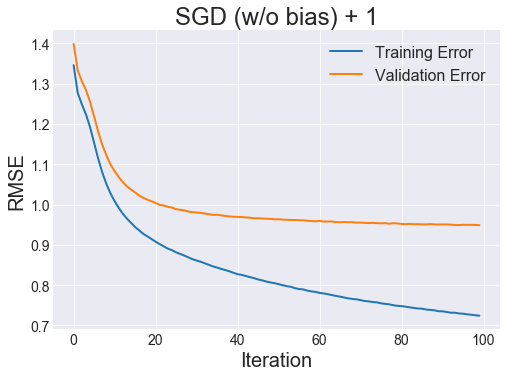

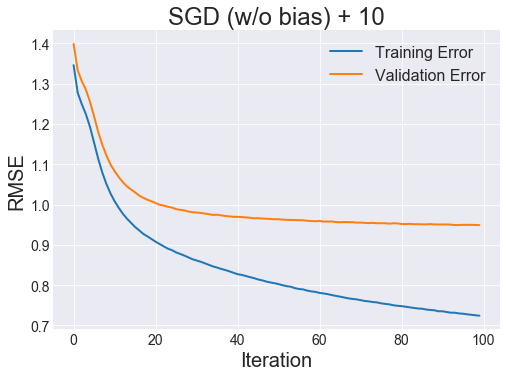

In [66]:
for k in range(len(regRange)):
    mf_sgd.plotHistory(historyList[k], title = 'SGD (w/o bias) + {}'.format(regRange[k]))
    print("Training error : {0:.2f}".format(history_bals['trainError']))
    print("Validation error : {0:.2f}".format(history_bals['valError']))
    
    

In [ ]:
# Test impact of factor K
factorsRange = [1, 3, 5, 7, 10, 20]
trainErrors = []
valErrors = []
for K in factorsRange:
    R_als = Df2Numpy(ratings)
    mf_als = MatrixFactorization(R_als, 
                                 nFactors=5, 
                                 lambdaReg=0.1, 
                                 muReg=0.1, 
                                 userBiasReg=0.0,
                                 movieBiasReg=0.0,
                                 trainFrac=0.8, 
                                 valFrac=0.2, 
                                 testFrac=0.0,
                                 withBias=False,
                                 maxIter =50)
    _, _, history_als = mf_als.stochasticGradientDescent(False)
    trainErrors.append = history_als.history['trainError']
    valErrors.append = history_als.history['valError']

 83% (10 of 12) |####################    | Elapsed Time: 0:10:35 ETA:   0:03:10

In [49]:
# 

0.6972893271922261
0.7880399863834019


In [45]:
def best_initialization(mean, sd):
    lowest_error = math.inf
    best_init = None
    bestUV = (None,None)
    errors = []
    for config in itertools.product(mean, sd):
        mean, sd = config
        R = Df2Numpy(ratings)
        mf = MatrixFactorization(R, nFactors=3, lambdaReg=0.1, muReg=0.1, alpha=0.01, trainFrac=0.8, valFrac=0.2, testFrac=0.0, maxIter=5, mean = mean , sd=sd)
        #U, V, history = mf.stochasticGradientDescent(True)
        U, V, history = mf.als(True)
        print(history['valError'])
        errors.append(history['valError'])
        if history['valError'] < lowest_error:
            lowest_error = history['valError']
            best_init = config
            bestUV = U,V
    return U,V,lowest_error, best_init, errors

In [ ]:
#best_initialization([-5,-4,-3,-2,-1,0,1,2,3,4,5],[0.5])

0.49123820898993686
0.49829598948087783
0.4920813984697845
0.4746826859591383


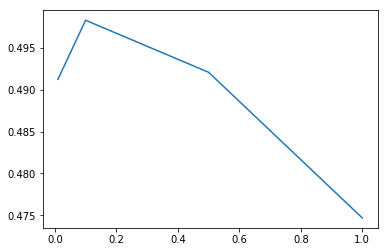

In [46]:
d = best_initialization([1],[0.01,0.1,0.5,1])[4]
plt.plot([0.01,0.1,0.5,1],d)

#ALS VALIDATION ERROR EN FONCTION DE STANDARD DEVIATION A MEAN=1 

In [9]:
def plot_best_init(mean):
    d = best_initialization([mean],[0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
    plt.plot([0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d)

1.3090499006414436
1.2805005340299587
1.2758938337093702
1.2771303170568933
1.3686500065377503
1.3155144711533049
1.372378809105249
1.410437373536466
1.5862473763684974
0.7711914406797539
0.7862747024024728
0.7820779836865048
0.7917221291560071
0.7951768139542993
0.8196293993025917
0.8316698495590706
0.875150309065631
0.9741709365111312
0.8903521528921858
0.9161713552224857
0.8671264253828596
0.8915230831916717
0.9012252717250566
0.9231883191425806
0.9222777400237846
0.9566885094805934
1.0324153561276432
1.1297095630339913
0.9607848653985366
0.9387317469318417
0.8957660435594066
0.9456939782596607
0.9373621155047897
0.9409366577275811
1.1049537105735687
1.1760638076587895


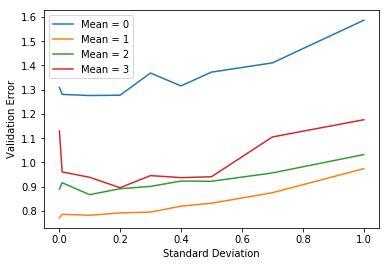

In [10]:
plt.xlabel("Standard Deviation")
plt.ylabel("Validation Error")
d = best_initialization([0],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d, label="Mean = 0")
d = best_initialization([1],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d, label="Mean = 1")
d = best_initialization([2],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d, label="Mean = 2")
d = best_initialization([3],[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1])[4]
plt.plot([0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.7,1], d,label="Mean = 3")
plt.legend()
plt.show()